### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display
import pyproj

#For plotting
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

from importlib import reload

In [2]:
def getXYproj(source_url):
    """
    Given netCDF-file, returns X, Y arrays and projection.
    """
    try:
        ncfile = Dataset(source_url)
        var = ncfile.variables['projection_stere']
        proj4 = var.__getattr__('proj4')
        X = ncfile.variables['X'][:]
        Y = ncfile.variables['Y'][:]
    except Exception as e:
        raise e
    finally:
        ncfile.close()
    
    proj = pyproj.Proj(proj4)
    
    return X, Y, proj

    
def lonlat2xygpuocean(source_url, lon, lat, x0, y0, norkyst = True):
    """
    Takes in NetCDF-file, x, y coordinates(single or lists) and x0, y0 of GPU Ocean-domain. 
    Returns x, y projection of lon, lat.
    If X, Y and proj are given, netCDF-file is not opened.
    """
    if norkyst:
        X, Y, proj = getXYproj(source_url)
    else:
        proj_str= '+proj=stere +ellps=WGS84 +lat_0=90.0 +lat_ts=60.0 +x_0=3192800 +y_0=1784000 +lon_0=70'
        proj = pyproj.Proj(proj_str)
        try:
            ncfile = Dataset(source_url)
            lon_rho = ncfile.variables['lon_rho'][:]
            lat_rho = ncfile.variables['lat_rho'][:]
        except Exception as e:
            raise e
        finally:
            ncfile.close()
            
        X, Y = proj(lon_rho, lat_rho, inverse = False)
        X = X[0]
        Y = Y[:,0] 
    
    #Finding tentative x,y(not for a specific domain)
    x, y = proj(lon,lat, inverse = False)

    #Find new x,y in gpuocean coordinates for initial position
    x = x - X[int(x0) + 2]
    y = y- Y[int(y0) + 2]
    
    return x, y

def xygpuocean2lonlat(source_url, x, y, x0, y0, X= None, Y= None, proj = None):
    """
    Takes in NetCDF-file, longitude and latitude coordinates and x0, y0 of GPU Ocean-domain. 
    Returns lon, lat equivalent of x, y. 
    If X, Y and proj are given, netCDF-file is not opened.
    """
    if (X is None) or (Y is None) or (proj is None):
        X, Y, proj = getXYproj(source_url)
        
    x = x + X[x0+2]
    y = y + Y[y0+2]
    
    lon, lat = proj(x, y, inverse = True)

    return lon, lat


In [3]:
source_url = "C:\\Users\\florianb\\Downloads\\NorKyst-800m_ZDEPTHS_his.an.2019071600.nc"

In [4]:
nc = Dataset(source_url)

In [5]:
lat1, lon1 = 58.46175,  8.77245
lat2, lon2 = 57.72500, 10.57919

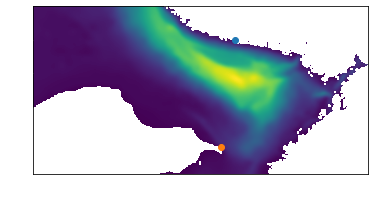

In [6]:
mask = nc["zeta"][0,0:250,0:500].mask.copy()
plt.imshow(np.ma.array(nc["h"][0:250,0:500], mask=mask.copy()), origin="lower")
plt.scatter(300,200)
plt.scatter(280,40)

In [7]:
x1, y1 = 300, 200
x2, y2 = 280, 40

In [8]:
x, y = x1, y1
x_step, y_step = x2-x1, y2-y1

all_xs, all_ys = [x1], [y1]

while all_xs[-1] != x2 or all_ys[-1] != y2:
    x = x + x_step/200
    y = y + y_step/200
    if all_xs[-1] != round(x) or all_ys[-1] != round(y):
        all_xs.append(round(x))
        all_ys.append(round(y))

In [9]:
xs, ys = [], []
for i in range(len(all_xs)):
    try:
        nc["zeta"][0,all_ys[i],all_xs[i]].mask 
    except:
        xs.append(all_xs[i])
        ys.append(all_ys[i])

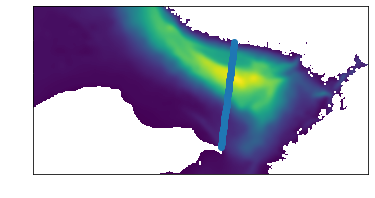

In [10]:
plt.imshow(np.ma.array(nc["h"][0:250,0:500], mask=mask.copy()), origin="lower")
plt.scatter(xs, ys)

In [11]:
lats = []
for i in range(len(xs)):
    lats.append(float(nc["lat"][ys[i],xs[i]].data))

In [12]:
depths = nc["depth"][:].data

In [13]:
temps = []
for i in range(len(xs)):
    temps.append(nc["temperature"][0,:,ys[i],xs[i]])
temps = np.ma.array(temps)

In [14]:
sals = []
for i in range(len(xs)):
    sals.append(nc["salinity"][0,:,ys[i],xs[i]])
sals = np.ma.array(sals)

In [15]:
import seawater as sw

In [16]:
pressures = np.zeros((len(lats), len(depths)))
for l in range(len(lats)):
    for d in range(len(depths)):
        pressures[l,d] = sw.eos80.pres(depths[d],lats[l])

In [17]:
densities = np.ma.array(np.zeros_like(temps),mask=temps.mask.copy())
for l in range(len(lats)):
    for d in range(len(depths)):
        if not densities.mask[l,d]:
            densities[l,d] = sw.eos80.dens(sals[l,d],temps[l,d],pressures[l,d])

In [18]:
densities_show = densities[:,0]
d_up = 0 
for i in range(len(nc["depth"][:13].data)):
    d = nc["depth"][:-1].data[i]
    densities_show = np.ma.vstack([densities_show, np.tile(densities[:,i],(int(d - d_up),1))])
    d_up = d

Text(0, 0.5, 'Depth')

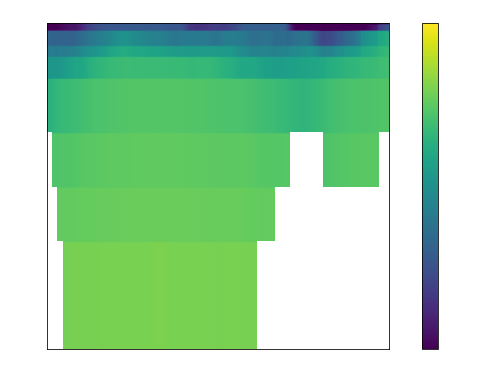

In [19]:
fig = plt.figure(figsize=(12,6))
plt.imshow(densities_show[0:150,:], vmin=1020, vmax=1030)
plt.colorbar()
plt.title("Densities")
plt.ylabel("Depth")

Now with s-level file

Re-using the coordinate vector

In [20]:
ssource_url = "C:\\Users\\florianb\\Downloads\\ocean_his.an.20190716.nc"

In [21]:
snc = Dataset(ssource_url)

In [24]:
s_rhos = snc["s_rho"][:].data

shs = []
for i in range(len(lats)):
    shs.append(snc["h"][ys[i],xs[i]].data.item())

In [73]:
sdepths = np.zeros((len(shs),len(s_rhos)))
for l in range(len(shs)):
    for s in range(len(s_rhos)):
        sdepths[l,s] = shs[l]*s_rhos[s]

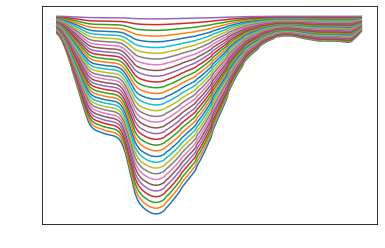

In [74]:
for s in range(len(s_rhos)):
    plt.plot(sdepths[:,s])

In [37]:
stemps = []
for i in range(len(xs)):
    stemps.append(snc["temp"][0,:,ys[i],xs[i]].data)
stemps = np.array(stemps)

In [42]:
ssals = []
for i in range(len(xs)):
    ssals.append(snc["salt"][0,:,ys[i],xs[i]].data)
ssals = np.array(ssals)

In [55]:
spressures = np.zeros((len(lats), len(s_rhos)))
for l in range(len(lats)):
    for d in range(len(s_rhos)):
        spressures[l,d] = sw.eos80.pres(-shs[l]*s_rhos[d],lats[l])

In [56]:
sdensities = np.zeros_like(stemps)
for l in range(len(lats)):
    for d in range(len(s_rhos)):
        sdensities[l,d] = sw.eos80.dens(ssals[l][d],stemps[l][d],spressures[l][d])

In [57]:
sdensities_show = np.ma.array(np.zeros((len(lats),1000)))
for l in range(len(lats)):
    d_up = 0 
    for i in reversed(range(len(s_rhos))):
        d = round(-(shs[l]*s_rhos[i]))
        sdensities_show[l,d_up:d] = sdensities[l][i]
        d_up = d
sdensities_show.mask = (sdensities_show==0)

Text(0, 0.5, 'Depth')

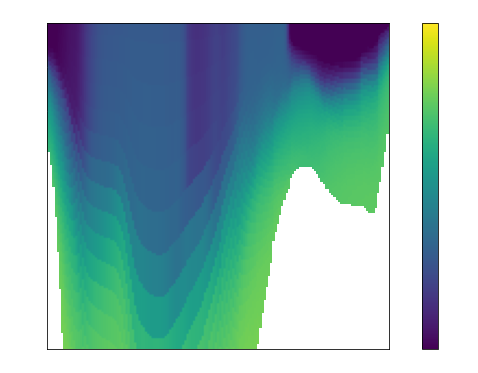

In [60]:
fig = plt.figure(figsize=(12,6))
plt.imshow(sdensities_show.T[0:150], vmin=1020, vmax=1030)
plt.colorbar()
plt.title("Densities")
plt.ylabel("Depth")

Analysis of differences in results

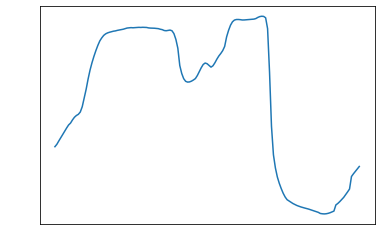

In [87]:
plt.plot(densities_show[0,:])
plt.title("Surface density (z-levels)")

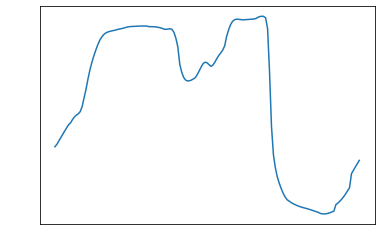

In [88]:
plt.plot(sdensities_show[:,0])
plt.title("Surface density (s-levels)")

Example location (index 50)

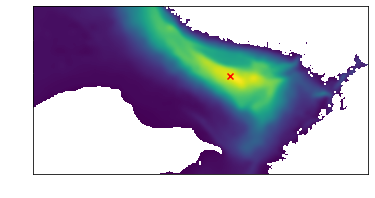

In [125]:
plt.imshow(np.ma.array(nc["h"][0:250,0:500], mask=mask.copy()), origin="lower")
plt.scatter(xs[50], ys[50], marker="x", c="red")

In [121]:
nc["lat"][ys[50],xs[50]], snc["lat_rho"][ys[50],xs[50]]

(masked_array(data=58.22356832,
              mask=False,
        fill_value=1e+20),
 masked_array(data=58.22356832,
              mask=False,
        fill_value=1e+20))

In [122]:
nc["lon"][ys[50],xs[50]], snc["lon_rho"][ys[50],xs[50]]

(masked_array(data=9.40334075,
              mask=False,
        fill_value=1e+20),
 masked_array(data=9.40334075,
              mask=False,
        fill_value=1e+20))

Text(0.5, 1.0, 'Vertical temperature profile (z-levels)')

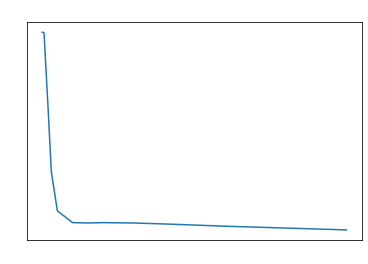

In [123]:
plt.plot(depths[0:13], nc["temperature"][0,0:13,ys[50],xs[50]])
plt.title("Vertical temperature profile (z-levels)")

Text(0.5, 1.0, 'Vertical temperature profile (s-levels)')

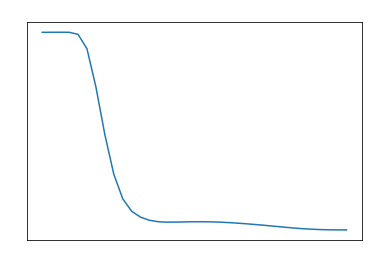

In [124]:
plt.plot(np.flip(-sdepths[50]),np.flip(snc["temp"][0,:,ys[50],xs[50]]))
plt.title("Vertical temperature profile (s-levels)")